## Import Library

In [1]:
!pip install optuna

In [2]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5007 sha256=f33c29df874bdaa8c1ea31811eab84680aea2cc841a04434b2954a583d8e0099
  Stored in directory: /root/.cache/pip/wheels/aa/cd/d1/51736c6b95846b2613a520ce146a8f305c4016a987bc9faec7
Successfully built timeout-decorator


In [3]:
!pip install -U xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [4]:
import os

cpu_count = os.cpu_count()
print(f"Number of CPU cores: {cpu_count}")

Number of CPU cores: 4


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import optuna
import timeout_decorator
from timeout_decorator.timeout_decorator import TimeoutError
import joblib

## Import Dataset

In [6]:
df = pd.read_csv('/kaggle/input/preprocessed-fake-reviews-dataset/preprocessed-fake-reviews-dataset.csv')

In [7]:
df.head()

,category,rating,label,text_,cleaned_text
0,Home_and_Kitchen_5,5.0,1,"Love this! Well made, sturdy, and very comfor...",Love this Well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5.0,1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original Ive...
2,Home_and_Kitchen_5,5.0,1,This pillow saved my back. I love the look and...,This pillow saved my back I love the look and ...
3,Home_and_Kitchen_5,1.0,1,"Missing information on how to use it, but it i...",Missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...,Very nice set Good quality We have had the set...


In [8]:
df.isnull().sum()

category        0
rating          0
label           0
text_           0
cleaned_text    1
dtype: int64

In [9]:
df['cleaned_text'] = df['cleaned_text'].fillna("")

In [10]:
df.isnull().sum()

category        0
rating          0
label           0
text_           0
cleaned_text    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      40432 non-null  object 
 1   rating        40432 non-null  float64
 2   label         40432 non-null  int64  
 3   text_         40432 non-null  object 
 4   cleaned_text  40432 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [12]:
df.describe()

,rating,label
count,40432.000000,40432.000000
mean,4.256579,0.500000
std,1.144354,0.500006
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.500000
75%,5.000000,1.000000
max,5.000000,1.000000


## Data Splitting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [14]:
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()

print("Jumlah Real Review Train (0):", train_label_counts[0])
print("Jumlah Fake Review Train (1):", train_label_counts[1])
print("Jumlah Real Review Test (0):", test_label_counts[0])
print("Jumlah Fake Review Test (1):", test_label_counts[1])

Jumlah Real Review Train (0): 16172
Jumlah Fake Review Train (1): 16173
Jumlah Real Review Test (0): 4044
Jumlah Fake Review Test (1): 4043


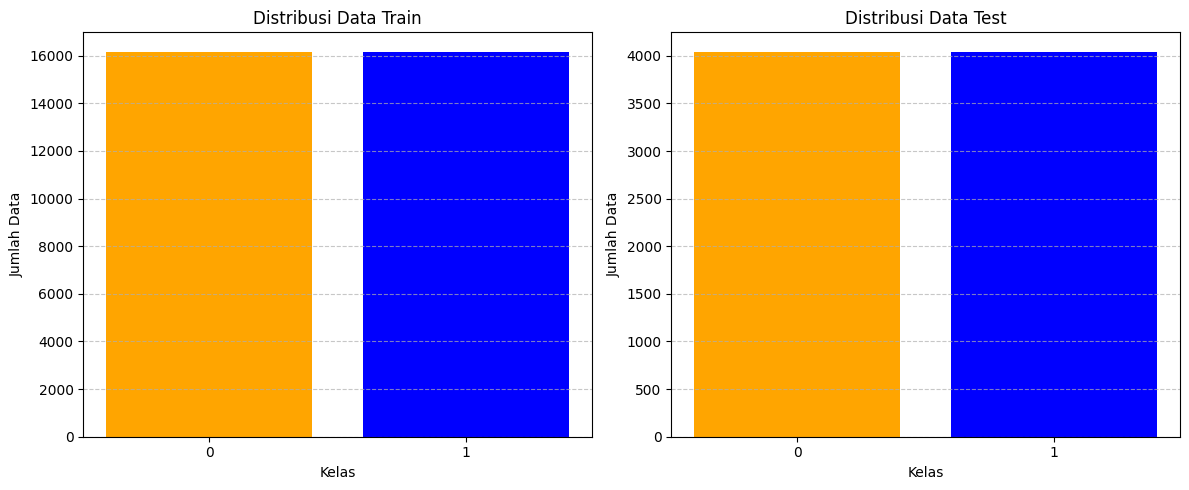

In [15]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color=['blue', 'orange'])
axes[0].set_title('Distribusi Data Train')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Jumlah Data')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(test_counts.keys(), test_counts.values(), color=['blue', 'orange'])
axes[1].set_title('Distribusi Data Test')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Jumlah Data')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## TF-IDF

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=30, max_df=0.90, strip_accents='unicode', sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

In [17]:
print("Jumlah fitur yang diekstrak:", len(vectorizer.vocabulary_))

Jumlah fitur yang diekstrak: 10256


## Random Forest

In [18]:
@timeout_decorator.timeout(900, use_signals=False)
def train(n_estimators, min_samples_split, min_samples_leaf, max_features):
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    rf_model.fit(X_train_tfidf, y_train)
    return rf_model

def objective(trial):    
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    try:
      rf_model = train(n_estimators, min_samples_split, min_samples_leaf, max_features)
      y_pred = rf_model.predict(X_test_tfidf)
      accuracy = accuracy_score(y_test, y_pred)
    except TimeoutError:
      raise optuna.exceptions.TrialPruned()
    return accuracy

In [19]:
# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.enqueue_trial({
    "n_estimators": 100,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt"
})
study.optimize(objective, n_trials=40, n_jobs=4)

[I 2025-04-21 06:05:40,724] A new study created in memory with name: no-name-bba67afd-ba34-41a3-bd87-29628abe89d8
[I 2025-04-21 06:05:52,836] Trial 2 finished with value: 0.8992209719302584 and parameters: {'n_estimators': 206, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.8992209719302584.
[I 2025-04-21 06:06:02,063] Trial 4 finished with value: 0.8946457277111414 and parameters: {'n_estimators': 159, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.8992209719302584.
[I 2025-04-21 06:06:20,818] Trial 5 finished with value: 0.9036725609002102 and parameters: {'n_estimators': 291, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 5 with value: 0.9036725609002102.
[I 2025-04-21 06:07:34,264] Trial 0 finished with value: 0.9037962161493756 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'

In [20]:
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'n_estimators': 202, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best accuracy: 0.9126993940892791


In [21]:
# Re-training
best_params = study.best_params
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)
start = time.time()
rf_model.fit(X_train_tfidf, y_train)
print(f"Training Time: {time.time() - start:.2f} s")

Training Time: 12.45 s


In [22]:
# Evaluation
rf_y_pred = rf_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, rf_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, rf_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, rf_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9127
Presisi (Fake Review): 0.9376
Recall (Fake Review): 0.8842
F1-Score (Fake Review): 0.9101


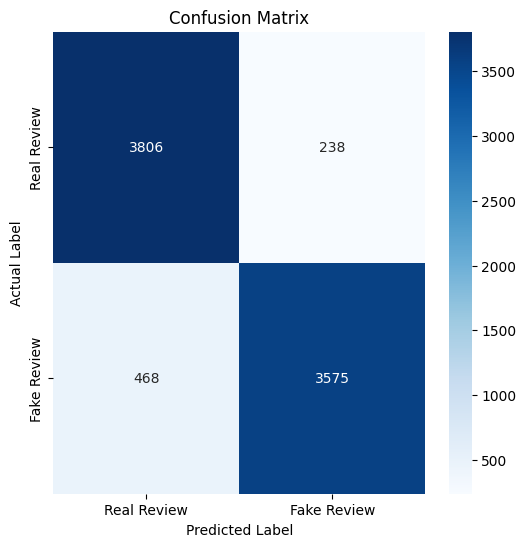

In [23]:
conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
print("Classification Report:")
print(classification_report(y_test, rf_y_pred, target_names=['Real Review', 'Fake Review']))

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.89      0.94      0.92      4044
 Fake Review       0.94      0.88      0.91      4043

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087



## SVM

In [25]:
@timeout_decorator.timeout(1500, use_signals=False)
def train(kernel, C):
    svm_model = SVC(kernel=kernel, C=C, random_state=42)
    svm_model.fit(X_train_tfidf, y_train)
    return svm_model

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)

    try:
      svm_model = train(kernel, C)
      y_pred = svm_model.predict(X_test_tfidf)
      accuracy = accuracy_score(y_test, y_pred)
    except TimeoutError:
      raise optuna.exceptions.TrialPruned()
    return accuracy

In [26]:
# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.enqueue_trial({
    "C": 1.0,
    "kernel": "rbf"
})
study.optimize(objective, n_trials=40, n_jobs=4)

[I 2025-04-21 06:42:56,167] A new study created in memory with name: no-name-0d62521c-fa3e-4770-a373-4d1fcc99bfba
[I 2025-04-21 06:51:18,075] Trial 1 finished with value: 0.9249412637566464 and parameters: {'kernel': 'sigmoid', 'C': 17.664952309164292}. Best is trial 1 with value: 0.9249412637566464.
[I 2025-04-21 06:58:40,750] Trial 3 finished with value: 0.8641028811673056 and parameters: {'kernel': 'rbf', 'C': 0.03097533718260072}. Best is trial 1 with value: 0.9249412637566464.
[I 2025-04-21 07:03:54,658] Trial 0 finished with value: 0.9504142450847038 and parameters: {'kernel': 'rbf', 'C': 1.0}. Best is trial 0 with value: 0.9504142450847038.
[I 2025-04-21 07:05:52,659] Trial 5 finished with value: 0.9381723754173364 and parameters: {'kernel': 'linear', 'C': 0.19713164645231282}. Best is trial 0 with value: 0.9504142450847038.
[I 2025-04-21 07:07:56,210] Trial 2 pruned. 
[I 2025-04-21 07:14:03,532] Trial 6 finished with value: 0.9449734141214294 and parameters: {'kernel': 'linear'

In [27]:
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'kernel': 'rbf', 'C': 1.184033132284523}
Best accuracy: 0.9512798318288611


In [28]:
# Re-training
best_params = study.best_params
svm_model = SVC(kernel=best_params['kernel'], C=best_params['C'], random_state=42)
start = time.time()
svm_model.fit(X_train_tfidf, y_train)
print(f"Training Time: {time.time() - start:.2f} s")

Training Time: 1058.30 s


In [29]:
# Evaluation
svm_y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, svm_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, svm_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, svm_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, svm_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9513
Presisi (Fake Review): 0.9602
Recall (Fake Review): 0.9416
F1-Score (Fake Review): 0.9508


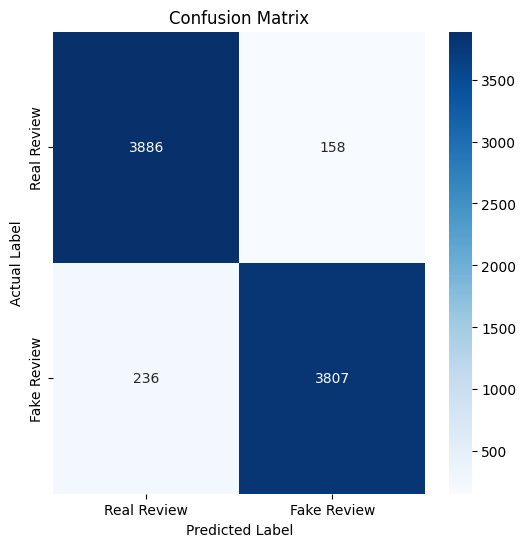

In [30]:
conf_matrix = confusion_matrix(y_test, svm_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [31]:
print("Classification Report:")
print(classification_report(y_test, svm_y_pred, target_names=['Real Review', 'Fake Review']))

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.94      0.96      0.95      4044
 Fake Review       0.96      0.94      0.95      4043

    accuracy                           0.95      8087
   macro avg       0.95      0.95      0.95      8087
weighted avg       0.95      0.95      0.95      8087



## Naive Bayes

In [32]:
@timeout_decorator.timeout(900, use_signals=False)
def train(alpha):
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_tfidf, y_train)
    return nb_model

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)

    try:
      nb_model = train(alpha)
      y_pred = nb_model.predict(X_test_tfidf)
      accuracy = accuracy_score(y_test, y_pred)
    except TimeoutError:
      raise optuna.exceptions.TrialPruned()
    return accuracy

In [33]:
# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.enqueue_trial({
    "alpha": 1.0
})
study.optimize(objective, n_trials=40, n_jobs=4)

[I 2025-04-21 10:12:50,793] A new study created in memory with name: no-name-dd63adcf-8be2-40f5-9d37-10fe5c0bfa7a
[I 2025-04-21 10:12:50,967] Trial 2 finished with value: 0.9047854581426982 and parameters: {'alpha': 0.010466261619518096}. Best is trial 2 with value: 0.9047854581426982.
[I 2025-04-21 10:12:50,974] Trial 1 finished with value: 0.9037962161493756 and parameters: {'alpha': 0.2705215581573571}. Best is trial 2 with value: 0.9047854581426982.
[I 2025-04-21 10:12:51,077] Trial 3 finished with value: 0.9046618028935328 and parameters: {'alpha': 0.06494567367791491}. Best is trial 2 with value: 0.9047854581426982.
[I 2025-04-21 10:12:51,098] Trial 0 finished with value: 0.9025596636577222 and parameters: {'alpha': 1.0}. Best is trial 2 with value: 0.9047854581426982.
[I 2025-04-21 10:12:51,187] Trial 5 finished with value: 0.9037962161493756 and parameters: {'alpha': 0.35010147584117607}. Best is trial 2 with value: 0.9047854581426982.
[I 2025-04-21 10:12:51,209] Trial 4 finish

In [34]:
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'alpha': 0.0010190750976428983}
Best accuracy: 0.9049091133918635


In [35]:
# Re-training
best_params = study.best_params
nb_model = MultinomialNB(alpha=best_params['alpha'])
start = time.time()
nb_model.fit(X_train_tfidf, y_train)
print(f"Training Time: {time.time() - start:.2f} s")

Training Time: 0.03 s


In [36]:
# Evaluation
nb_y_pred = nb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, nb_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, nb_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, nb_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, nb_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9049
Presisi (Fake Review): 0.9054
Recall (Fake Review): 0.9043
F1-Score (Fake Review): 0.9048


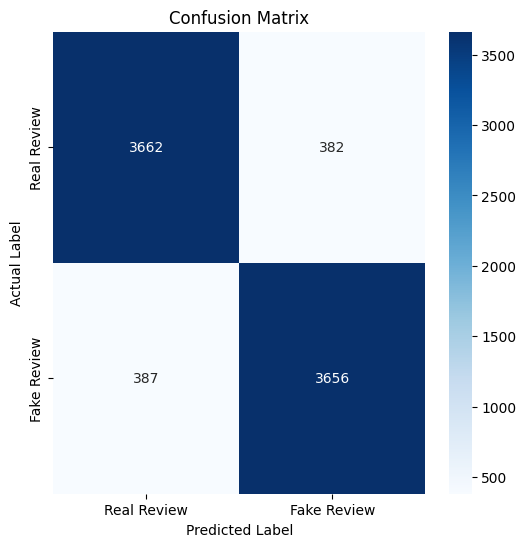

In [37]:
conf_matrix = confusion_matrix(y_test, nb_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
print("Classification Report:")
print(classification_report(y_test, nb_y_pred, target_names=['Real Review', 'Fake Review']))

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.90      0.91      0.90      4044
 Fake Review       0.91      0.90      0.90      4043

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087



## XGBoost

In [39]:
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

In [40]:
def objective(trial):
  params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
  }
  num_boost_round = trial.suggest_int("num_boost_round", 50, 500)

  xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)
  y_pred_prob = xgb_model.predict(dtest)
  y_pred = (y_pred_prob > 0.5).astype(int)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [41]:
# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.enqueue_trial({
    "max_depth": 6,
    "learning_rate": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "num_boost_round": 100
})
study.optimize(objective, n_trials=40, n_jobs=4)

[I 2025-04-21 10:12:53,678] A new study created in memory with name: no-name-4e9ad263-a548-4e95-9f2c-dd8b064ad2e0
[I 2025-04-21 10:13:56,061] Trial 1 finished with value: 0.8135278842586868 and parameters: {'max_depth': 4, 'learning_rate': 0.05859932776545744, 'subsample': 0.7638663945432799, 'colsample_bytree': 0.7440013397230805, 'num_boost_round': 70}. Best is trial 1 with value: 0.8135278842586868.
[I 2025-04-21 10:15:22,893] Trial 0 finished with value: 0.9028069741560529 and parameters: {'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'num_boost_round': 100}. Best is trial 0 with value: 0.9028069741560529.
[I 2025-04-21 10:17:09,324] Trial 2 finished with value: 0.8713985408680599 and parameters: {'max_depth': 5, 'learning_rate': 0.04835085548931775, 'subsample': 0.5761081166391884, 'colsample_bytree': 0.8187762092506732, 'num_boost_round': 233}. Best is trial 0 with value: 0.9028069741560529.
[I 2025-04-21 10:18:24,767] Trial 4 finished with valu

In [42]:
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'max_depth': 7, 'learning_rate': 0.26283755415710536, 'subsample': 0.9428539975754204, 'colsample_bytree': 0.6365927003716224, 'num_boost_round': 353}
Best accuracy: 0.9322369234574007


In [43]:
# Re-training
best_params = study.best_params
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42,
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree']
}

start = time.time()
xgb_model = xgb.train(params, dtrain, num_boost_round=best_params['num_boost_round'], evals=[(dtest, 'eval')], early_stopping_rounds=10)
print(f"Training Time: {time.time() - start:.2f} s")

[0]	eval-logloss:0.63548
[1]	eval-logloss:0.59320
[2]	eval-logloss:0.56206
[3]	eval-logloss:0.53411
[4]	eval-logloss:0.51410
[5]	eval-logloss:0.49465
[6]	eval-logloss:0.48097
[7]	eval-logloss:0.46858
[8]	eval-logloss:0.45741
[9]	eval-logloss:0.44673
[10]	eval-logloss:0.43791
[11]	eval-logloss:0.42904
[12]	eval-logloss:0.41921
[13]	eval-logloss:0.41174
[14]	eval-logloss:0.40645
[15]	eval-logloss:0.39971
[16]	eval-logloss:0.39341
[17]	eval-logloss:0.38771
[18]	eval-logloss:0.38291
[19]	eval-logloss:0.37776
[20]	eval-logloss:0.37121
[21]	eval-logloss:0.36614
[22]	eval-logloss:0.36110
[23]	eval-logloss:0.35661
[24]	eval-logloss:0.35367
[25]	eval-logloss:0.34989
[26]	eval-logloss:0.34620
[27]	eval-logloss:0.34279
[28]	eval-logloss:0.33964
[29]	eval-logloss:0.33690
[30]	eval-logloss:0.33426
[31]	eval-logloss:0.33174
[32]	eval-logloss:0.32928
[33]	eval-logloss:0.32595
[34]	eval-logloss:0.32362
[35]	eval-logloss:0.32136
[36]	eval-logloss:0.31932
[37]	eval-logloss:0.31756
[38]	eval-logloss:0.31

In [44]:
# Evaluation
xgb_y_pred_prob = xgb_model.predict(dtest)
xgb_y_pred = (xgb_y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, xgb_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, xgb_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, xgb_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, xgb_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9322
Presisi (Fake Review): 0.9421
Recall (Fake Review): 0.9211
F1-Score (Fake Review): 0.9315


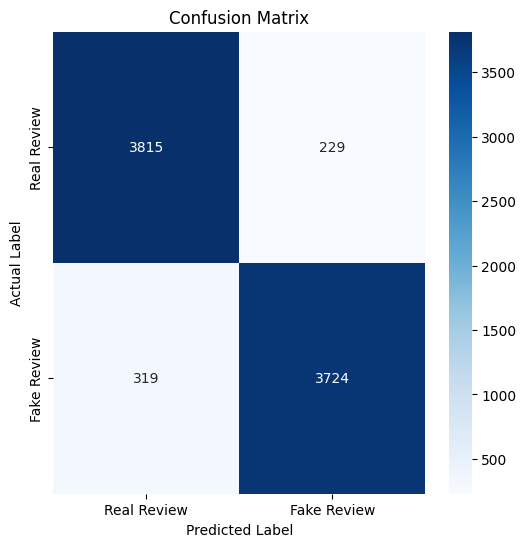

In [45]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [46]:
print("Classification Report:")
print(classification_report(y_test, xgb_y_pred, target_names=['Real Review', 'Fake Review']))

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.92      0.94      0.93      4044
 Fake Review       0.94      0.92      0.93      4043

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087



## Save Model

In [47]:
joblib.dump(rf_model, '/kaggle/working/rf.pkl')

['/kaggle/working/rf.pkl']

In [48]:
joblib.dump(svm_model, '/kaggle/working/svm.pkl')

['/kaggle/working/svm.pkl']

In [49]:
joblib.dump(nb_model, '/kaggle/working/nb.pkl')

['/kaggle/working/nb.pkl']

In [50]:
joblib.dump(xgb_model, '/kaggle/working/xgb.pkl')

['/kaggle/working/xgb.pkl']